<img src="images/example_images.png" style="width:600px;"/>

$$
\begin{aligned}
&|\psi\rangle \rightarrow |0010\rangle|0110\rangle|1010\rangle|0101\rangle &\rightarrow \frac{1}{\sqrt{4}}(0010011000100000)^T\\
&|\phi_0\rangle \rightarrow |0010\rangle|0110\rangle|1010\rangle &\rightarrow \frac{1}{\sqrt{3}}(0010001000100000)^T\\
&|\phi_1\rangle \rightarrow |0110\rangle|1010\rangle|0001\rangle &\rightarrow \frac{1}{\sqrt{3}}(0100001000100000)^T\\
&|\phi_2\rangle \rightarrow |0000\rangle|0100\rangle|1000\rangle &\rightarrow \frac{1}{\sqrt{3}}(1000100010000000)^T\\
&|\phi_3\rangle \rightarrow |0000\rangle|0100\rangle|1000\rangle|1001\rangle &\rightarrow \frac{1}{\sqrt{4}}(1000100011000000)^T
\end{aligned}
$$

# Oracle W
$$
j = \text{Index of training image}\\
|0^n\rangle \xrightarrow{\mathcal{V}}|\psi\rangle\\
|j\rangle|0^n\rangle\xrightarrow{\mathcal{W}}|j\rangle|\phi_j\rangle
$$

Example:

$$
|0^n\rangle \xrightarrow{\mathcal{V}}\frac{1}{\sqrt{11}}|1231\rangle\\
|00\rangle|0^n\rangle\xrightarrow{\mathcal{W}}|00\rangle\frac{1}{\sqrt{11}}|1130\rangle
$$

Variables:

$$
\begin{aligned}
M &= \text{Amount of train images}\\
N &= \text{Dimension of Hilbert space}\\
m &= \log{M}\\
n &= \log{N}\\
b &= \text{Number of qubits required to store the fidelity value}
\end{aligned}
$$

## Circuits:
### Circuit complete
<img src="images/circuit_complete.png" style="width:800px;"/>

### Circuit Eamp
<img src="images/circuit_eamp.png" style="width:600px;"/>


In [35]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, \
                   Aer, BasicAer, assemble, transpile, execute
from qiskit.circuit.library.standard_gates.swap import SwapGate
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.extensions.quantum_initializer.initializer import Initialize
from qiskit.aqua import QuantumInstance
from qiskit.quantum_info.operators import Operator

from numpy import pi
import numpy as np
import math

In [10]:
# Variables
m = 2
n = 4

In [147]:
W_state_preparation_oracle_circuit = QuantumCircuit(m + n)
W_state_preparation_oracle_circuit.h(0)
W_oracle = W_state_preparation_oracle_circuit.to_gate()
W_oracle.name = "$W$"

In [148]:
V_state_preparation_oracle_circuit = QuantumCircuit(n)
V_oracle = V_state_preparation_oracle_circuit.to_gate()
V_oracle.name = "$V$"

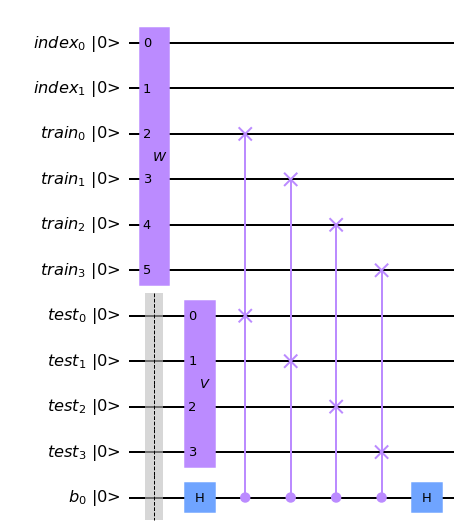

In [151]:
index_register = QuantumRegister(2, 'index')
train_register = QuantumRegister(4, 'train')
test_register = QuantumRegister(4, 'test')
B_register = QuantumRegister(1, 'b')
qc = QuantumCircuit(index_register, train_register, test_register, B_register)

qc.append(W_oracle, [*index_register[:],*train_register[:]])

qc.barrier(*test_register[:], B_register[0])
qc.append(V_oracle, *[test_register[:]])
qc.h(B_register[0])

# Ist das richtig?
for qubit in range (n):
    qc.cswap(B_register[0], train_register[qubit], test_register[qubit])
qc.h(B_register[0])

qc.draw(output="mpl", initial_state=True)

In [159]:
#def swap_test(phi_state, psi_state):
sv = Statevector.from_label('111111111')
qc = QuantumCircuit(n*2 + 1)
sv.evolve(qc)

circuit = QuantumCircuit(6)
circuit.append(Initialize("1+-"), range(3))
circuit.append(Initialize("101"), list(np.arange(3,6)))

#for qubit in range (n):
#    circuit.cswap(B_register[0], train_register[qubit], test_register[qubit])
#qc.h(B_register[0])
circuit.decompose().draw()

┌───┐┌───┐
q_0: ─|0>─┤ X ├┤ H ├
          ├───┤└───┘
q_1: ─|0>─┤ H ├─────
          ├───┤     
q_2: ─|0>─┤ X ├─────
          ├───┤     
q_3: ─|0>─┤ X ├─────
          └───┘     
q_4: ─|0>───────────
          ┌───┐     
q_5: ─|0>─┤ X ├─────
          └───┘

In [118]:
def swap_test(psi_state, phi_state):
    n = len(psi_state)
    qc = QuantumCircuit(n*2 + 1, 1)
    qc.append(Initialize(psi_state), range(n))
    qc.append(Initialize(phi_state), list(np.arange(n,n*2)))
    qc.h(n*2)

    for qubit in range (n):
        qc.cswap(n*2, qubit, n+qubit)
    
    qc.h(n*2)
    qc.measure(n*2, 0)
    return qc

In [161]:
psi_state_one = "000100010"
phi_state_one = "000010000"

psi_state_two = "111111111"
phi_state_two = "111111111"

qc = swap_test(psi_state_two, phi_state_two)
#qc.draw(output="mpl")

simulator = BasicAer.get_backend('qasm_simulator')

job = execute(qc, simulator, shots = 1000)

result = job.result()
counts = result.get_counts(qc)

print(counts)

#print(result)

{'0': 1000}


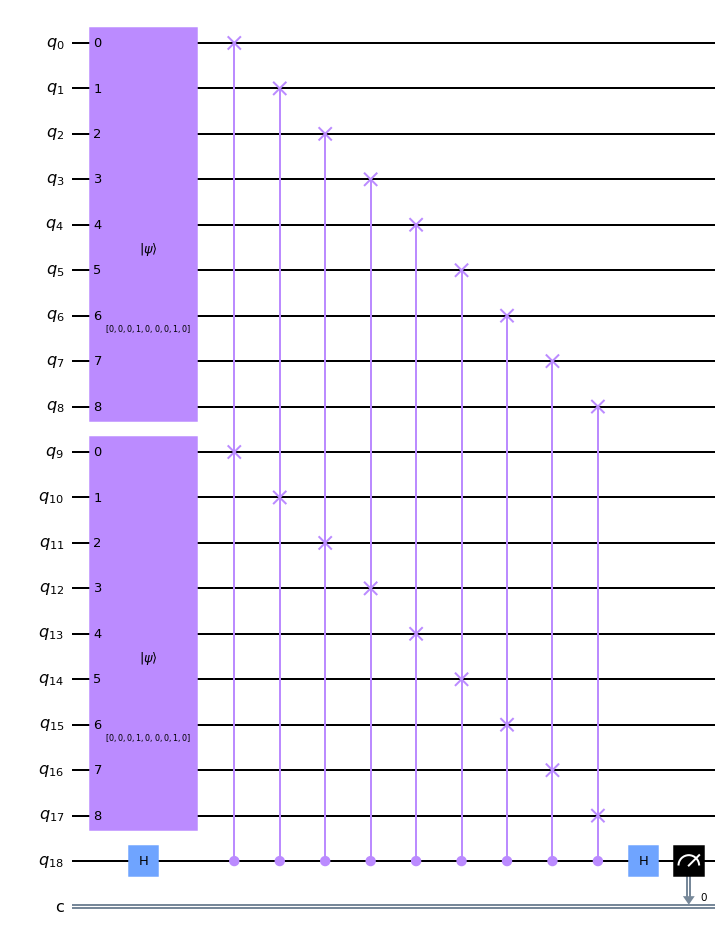

In [154]:
qc.draw(output="mpl")

In [11]:
qc = QuantumCircuit(4)

#qc.x(0)
qc.x(1)
#qc.x(2)
#qc.x(3)

# Let's see the result
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
final_state = svsim.run(qobj).result().get_statevector()

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit_textbook.tools import array_to_latex
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

$$
|\psi\rangle \rightarrow |0010\rangle|0110\rangle|1010\rangle|0101\rangle \rightarrow \frac{1}{\sqrt{4}}(0010011000100000)^T
$$

$$
W =
\frac{1}{\sqrt{4}}  \quad
\begin{pmatrix}
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{pmatrix}
$$

In [18]:
psi_column = np.array([0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0])
W = np.ones((16, 16))
W[:,0] = psi_column
W

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [23]:
controls = QuantumRegister(4)
circuit = QuantumCircuit(controls)

cx = Operator(W)
circuit.unitary(cx, [0, 1], label='cx')
circuit.draw()

ExtensionError: 'Input matrix is not unitary.'

In [45]:
def perform_unitary_check(W):
    array_to_latex(W, pretext="\\text{W} = ")
    W_transposed = np.transpose(W)
    array_to_latex(W_transposed, pretext="\\text{W}^* = ")
    result = np.dot(W, W_transposed).round()
    array_to_latex(result, pretext="W^*W = ")

In [48]:
W = np.array([[1,1],[1,-1]])
perform_unitary_check(W)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [57]:
W = np.array([
    [0,1,1,1],
    [1,0,1,-1],
    [1,-1,0,1],
    [1,1,-1,0]
])
perform_unitary_check(W)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [96]:
v = np.array([[1,1]])
e1 = np.array([[1,0]])
w = v/np.linalg.norm(v) - e1
np.identity(2) - 2*((np.dot(w.T, w))/(np.dot(w, w.T)))

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [100]:

test = np.zeros(v.size)
test[0] = 1
test

array([1., 0.])

In [93]:
np.dot(w, w.T) # = w.T*w

array([[0.58578644]])

In [92]:
np.dot(w.T, w) # = w*w.T

array([[ 0.08578644, -0.20710678],
       [-0.20710678,  0.5       ]])

In [101]:
def create_unitary(v):
    dim = v.size
    e1 = np.zeros(dim)
    e1[0] = 1
    w = v/np.linalg.norm(v) - e1
    return np.identity(dim) - 2*((np.dot(w.T, w))/(np.dot(w, w.T)))

In [102]:
v = np.array([[1,1]])
create_unitary(v)

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [106]:
v = np.array([[0,1,1,1]])
create_unitary(v).round()

array([[ 0.,  1.,  1.,  1.],
       [ 1.,  1., -0., -0.],
       [ 1., -0.,  1., -0.],
       [ 1., -0., -0.,  1.]])